### Imports

In [ ]:
!pip install rasterio

In [ ]:
import tensorflow as tf
# from hub import Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import *
import glob 
import skimage.io as io
import skimage.transform as trans
import rasterio
import cv2

print(tf.__version__)
# check if notebook is using GPU
tf.test.gpu_device_name()

2.4.0


'/device:GPU:0'

### Variables input


In [ ]:
# dataset from https://www.kaggle.com/carlolepelaars/camvid
dataset_path = '/content/drive/MyDrive/semantic_drone_dataset'

classes = ['tree', 'gras', 'other vegetation', 'dirt', 'gravel', 'rocks', 
           'water', 'paved area', 'pool', 'person', 'dog', 'car', 'bicycle', 
           'roof', 'wall', 'fence', 'fence-pole', 'window', 'door', 'obstacle']
num_classes = 23
batch_size = 5
input_size = (256, 256)
input_shape = input_size + (3,)
file_extension = ".jpg"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load data

#### Data generator class

In [ ]:
class DataGenerator():
    def __init__(self, batch_size, dataset_path, aug_dict,
                    image_color_mode="rgb",
                    mask_color_mode="grayscale",
                    num_class=2, target_size=(256,256)):
        self.batch_size = batch_size
        self.dataset_path = dataset_path
        self.aug_dict = aug_dict
        self.image_color_mode = image_color_mode
        self.mask_color_mode = mask_color_mode
        self.num_class = num_class
        self.target_size = target_size
        self.build_train_val_generators()

    def preprocess_data(self, img, mask, num_class):
        img = img / 255
        mask = mask[:, :, :, 0]
        new_mask = np.reshape(mask, [mask.shape[0], mask.shape[1] * mask.shape[2]])
        new_mask = to_categorical(new_mask, num_classes=int(mask.max()+1), dtype='float32')
        mask = new_mask
        return (img,mask)

    def build_train_val_generators(self, seed=1):
        image_datagen = ImageDataGenerator(**self.aug_dict, validation_split=0.2)
        mask_datagen = ImageDataGenerator(**self.aug_dict, validation_split=0.2)
        test_image_datagen = ImageDataGenerator()
        test_mask_datagen = ImageDataGenerator()
        print("Training data")
        image_generator_train = image_datagen.flow_from_directory(
            directory=self.dataset_path,
            classes=['train'],
            class_mode=None,
            subset="training",
            color_mode=self.image_color_mode,
            target_size=self.target_size,
            batch_size=self.batch_size,
            shuffle=True,
            seed=seed)
        mask_generator_train = mask_datagen.flow_from_directory(
            directory=self.dataset_path,
            classes=['train_labels'],
            class_mode=None,
            subset="training",
            color_mode=self.mask_color_mode,
            target_size=self.target_size,
            batch_size=self.batch_size,
            shuffle=True,
            seed=seed)
        print("Validation data")
        image_generator_val = image_datagen.flow_from_directory(
            directory=self.dataset_path,
            classes=['train'],
            class_mode=None,
            subset="validation",
            color_mode=self.image_color_mode,
            target_size=self.target_size,
            batch_size=self.batch_size,
            shuffle=True,
            seed=seed)
        mask_generator_val = mask_datagen.flow_from_directory(
            directory=self.dataset_path,
            classes=['train_labels'],
            class_mode=None,
            subset="validation",
            color_mode=self.mask_color_mode,
            target_size=self.target_size,
            batch_size=1,
            shuffle=True,
            seed=seed)
        print("Test data")
        image_generator_test = test_image_datagen.flow_from_directory(
            directory=self.dataset_path,
            classes=['test'],
            class_mode=None,
            color_mode=self.image_color_mode,
            target_size=self.target_size,
            batch_size=self.batch_size,
            seed=seed)
        mask_generator_test = test_mask_datagen.flow_from_directory(
            directory=self.dataset_path,
            classes=['test_labels'],
            class_mode=None,
            color_mode=self.mask_color_mode,
            target_size=self.target_size,
            batch_size=1,
            seed=seed)

        self.train_generator_zip = zip(image_generator_train, mask_generator_train)
        self.val_generator_zip = zip(image_generator_val, mask_generator_val)
        self.test_generator_zip = zip(image_generator_test, mask_generator_test)

    def train_generator(self):
        for (img, mask) in self.train_generator_zip:
            img, mask = self.preprocess_data(img, mask, self.num_class)
            yield (img, mask)

    def val_generator(self):
        for (img, mask) in self.val_generator_zip:
            img, mask = self.preprocess_data(img, mask, self.num_class)
            yield (img, mask)

    def test_generator(self):
        for (img, mask) in self.test_generator_zip:
            img, mask = self.preprocess_data(img, mask, self.num_class)
            yield (img, mask)

    def get_length_train_generator(self):
        # TODO
        return

In [ ]:
def testGenerator(test_path,num_image=30,
                  target_size = (256, 256, 3),
                  as_gray = False, file_extension = '.png'):
    i = 0
    img_test_paths = glob.glob(test_path + "/*" + file_extension)
    for img_path in img_test_paths:
        if i <= num_image:
            if file_extension == '.tif':
                img = rasterio.open(img_path).read()
                img = np.transpose(img, (1, 2, 0))
            else:
                img = cv2.imread(img_path)
            img = img / 255
            img = trans.resize(img, target_size)
            img = np.reshape(img, (1,)+img.shape)
            i = i + 1

            yield img

#### Load data

Training data
Found 318 images belonging to 1 classes.
Found 318 images belonging to 1 classes.
Validation data
Found 79 images belonging to 1 classes.
Found 79 images belonging to 1 classes.
Test data
Found 3 images belonging to 1 classes.
Found 3 images belonging to 1 classes.
input shape: (256, 256, 3)
Mask shape: (65536, 23)


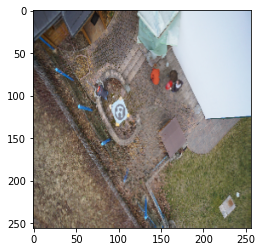

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

data_generator = DataGenerator(batch_size, dataset_path,
                               aug_dict=data_gen_args,
                               image_color_mode="rgb",
                               mask_color_mode="grayscale",
                               num_class=num_classes,
                               target_size=input_size)

train_dataset = data_generator.train_generator()
val_dataset = data_generator.val_generator()

for img, label in train_dataset:
    input_shape = img[0].shape
    print("input shape: {}".format(input_shape))
    print("Mask shape: {}".format(label[0].shape)) #1D array
    plt.imshow(img[0])
    break

### Models definition

In [ ]:
######### UNET ############
# Architectures reproduced using these architectures: https://awesomeopensource.com/project/shreyaspadhy/UNet-Zoo
# and with help from this github repo: https://github.com/zhixuhao/unet
def unet(pretrained_weights=None, input_shape=(256, 256, 1), num_classes=12):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis=3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)

    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)
    conv10 = Reshape([input_shape[0] * input_shape[1], num_classes])(conv10)
    
    model = Model(inputs=inputs, outputs=conv10)

    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

def simple_unet(pretrained_weights = None, input_shape = (256,256,1), num_classes=12):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, 3, activation='elu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='elu', padding='same', kernel_initializer='he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation='elu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='elu', padding='same', kernel_initializer='he_normal')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation='elu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='elu', padding='same', kernel_initializer='he_normal')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation='elu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='elu', padding='same', kernel_initializer='he_normal')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(128, 3, activation='elu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = Conv2D(128, 3, activation='elu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(64, 3, activation='elu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation='elu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(32, 3, activation='elu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation='elu', padding='same', kernel_initializer='he_normal')(conv7)

    conv8 = Conv2D(num_classes, 1, activation='softmax')(conv7)
    conv8 = Reshape([input_shape[0] * input_shape[1], num_classes])(conv8)
    model = Model(inputs=inputs, outputs=conv8)

    model.summary()

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


In [ ]:
# Model features
checkpoint_file = 'checkpoint_{}.h5'.format("unet")
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_file,
    format='h5',
    verbose=1,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1,
    mode='min', min_lr=2e-10)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)


### Training

In [ ]:
model = unet(input_shape=input_shape, num_classes=num_classes)

In [ ]:
model.compile(optimizer=Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_dataset_length = int(len(glob.glob(dataset_path + '/train/*' + file_extension))*0.8) + 1
print("There are {} training files".format(train_dataset_length))

There are 318 training files


In [ ]:
model.fit(train_dataset,
          steps_per_epoch=50, #train_dataset_length//batch_size
          epochs=100,
          class_weight=None,
          validation_data=val_dataset,
          validation_steps=5,
          callbacks=[model_checkpoint, reducelronplateau, early_stop])

10/10 [==============================] - 44s 5s/step - loss: 3.5890 - accuracy: 0.1101 - val_loss: 2.5413 - val_accuracy: 0.4179

Epoch 00001: val_loss did not improve from 2.45678


### Evaluation

In [ ]:
model.load_weights(checkpoint_file)
test_dataset_gen = data_generator.test_generator()
model.compile(optimizer=Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
val_loss, val_accuracy = model.evaluate(test_dataset_gen, steps=5, verbose=1)

50/50 [==============================] - 64s 1s/step - loss: 1.8659 - accuracy: 0.5922


### Prediction

In [ ]:
test_dataset = testGenerator(dataset_path + '/test', 
                             num_image=4,
                             target_size = (256, 256, 3),
                             as_gray = False,
                             file_extension = file_extension)

In [ ]:
argmax = tf.math.argmax(model.layers[-2].output, axis=3)

model = Model(inputs=model.input, outputs=argmax)
model.load_weights(checkpoint_file)
argmaxes = model.predict(test_dataset, verbose=1)
print("results shape: {}".format(argmaxes.shape))


3/3 [==============================] - 16s 8s/step
results shape: (3, 256, 256)


(1, 256, 256, 3)


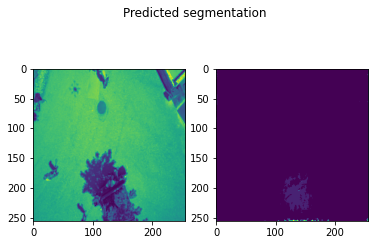

In [ ]:
test_dataset = testGenerator(dataset_path + '/test', 
                             num_image=4,
                             target_size = (256, 256, 3),
                             as_gray = False,
                             file_extension = file_extension)
for img_test in test_dataset:
  print(img_test.shape)
  plt.subplot(1,2,1)
  plt.suptitle("Image test")
  plt.imshow(img_test[0][:,:,1])
  plt.subplot(1,2,2)
  plt.suptitle("Predicted segmentation")
  plt.imshow(argmaxes[0])
  plt.show()
